In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install wfdb
!pip install pywavelets
!pip cache purge

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 73.2 MB/s eta 0:00:00
Files removed: 3001


In [ ]:
import psutil
import os

def print_memory_usage():
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    print(f"Current memory usage: {memory_info.rss / (1024 * 1024):.2f} MB")

In [ ]:
import os
import wfdb
import numpy as np
import pandas as pd
import urllib.request
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.signal
import gc

from keras.layers import Bidirectional, LSTM
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv1D
from keras.layers import LeakyReLU

from pywt import wavedec, dwt

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import StandardScaler, LabelEncoder


path_dataset = '/content/drive/MyDrive/mitdb/physionet.org/files/mitdb/1.0.0'
SR = 360
Time_to_middle_with = 3
used_symbols = ['N', 'V', '/', 'L', 'R']

def load_ECG_file(path):
    record = wfdb.rdrecord(path)
    annotation = wfdb.rdann(path, 'atr')
    signal = record.p_signal[:, 0]
    symbol = annotation.symbol
    index = annotation.sample
    return signal, symbol, index

def make_dataset(Patients, Time_to_middle_with, used_symbols):
    X_out = {symbol: [] for symbol in used_symbols}
    y_out = {symbol: [] for symbol in used_symbols}
    total_symbols = 0
    excluded_symbols = 0

    for patient in Patients:
        p_signal, p_symbol, p_index = load_ECG_file(os.path.join(path_dataset, patient))

        for i, symbol in enumerate(p_symbol):
            if symbol in used_symbols:
                total_symbols += 1
                Start = p_index[i] - (Time_to_middle_with * SR)
                End = Start + (2 * Time_to_middle_with * SR)
                if Start >= 0 and End <= len(p_signal):
                    Sig = p_signal[Start:End]
                    X_out[symbol].append(Sig)
                    y_out[symbol].append(symbol)
                else:
                    excluded_symbols += 1

    for symbol in used_symbols:
        X_out[symbol] = np.array(X_out[symbol])
        y_out[symbol] = np.array(y_out[symbol])

    print(f"Total symbols processed: {total_symbols}")
    print(f"Excluded symbols due to slicing: {excluded_symbols}")
    return X_out, y_out

patients = ['100','101','102','103','104','105','106','107',
            '108','109','111','112','113','114','115','116',
            '117','118','119','121','122','123','124','200',
            '201','202','203','205','207','208','209','210','212','213','214','215','217','219','220','221',
            '222','223','228','230','231','232','233','234']

X, y = make_dataset(patients, Time_to_middle_with, used_symbols)



total_collected_symbols = sum(len(v) for v in y.values())
print(f"Total collected symbols: {total_collected_symbols}")

Total symbols processed: 104544
Excluded symbols due to slicing: 350
Total collected symbols: 104194


In [ ]:

X_combined = np.concatenate([X[symbol] for symbol in used_symbols], axis=0)
y_combined = np.concatenate([y[symbol] for symbol in used_symbols], axis=0)


print(f"Combined X shape: {X_combined.shape}")
print(f"Combined y shape: {y_combined.shape}")

# 데이터와 레이블의 순서를 확인
print(f"Data examples: {X_combined[74780:75500]}")  # 처음 5개 데이터 예시 출력
print(f"Label examples: {y_combined[74780:75500]}")  # 처음 5개 레이블 예시 출력

del X, y
gc.collect()

print_memory_usage()

Combined X shape: (104194, 2160)
Combined y shape: (104194,)
Data examples: [[-0.415 -0.405 -0.395 ... -0.255 -0.275 -0.3  ]
 [-0.305 -0.3   -0.295 ... -0.24  -0.24  -0.23 ]
 [-0.3   -0.295 -0.29  ... -0.235 -0.225 -0.24 ]
 ...
 [-0.27  -0.275 -0.265 ... -0.15  -0.155 -0.165]
 [-0.27  -0.29  -0.325 ... -0.29  -0.27  -0.26 ]
 [-0.285 -0.27  -0.27  ... -0.015 -0.01   0.015]]
Label examples: ['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'V' 'V' 'V'
 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V'
 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V'
 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V'
 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V'
 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V'
 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V'
 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V'
 'V' 'V' 'V' 'V' 'V' 'V'

In [ ]:
from collections import Counter

# y_combined는 위에서 설명한 대로 이미 결합된 레이블 데이터입니다.
symbol_counts = Counter(y_combined)

# 심볼별 개수 출력
for symbol, count in symbol_counts.items():
    print(f"Symbol {symbol}: {count} occurrences")

Symbol N: 74795 occurrences
Symbol V: 7113 occurrences
Symbol /: 6999 occurrences
Symbol L: 8052 occurrences
Symbol R: 7235 occurrences


In [ ]:
from sklearn.utils import shuffle

# X_combined와 y_combined는 위에서 설명한 대로 이미 결합된 데이터와 레이블입니다.
X_shuffled, y_shuffled = shuffle(X_combined, y_combined, random_state=42)

# 셔플된 데이터와 레이블의 처음 5개 샘플을 출력하여 확인
print("First 5 shuffled data samples:")
print(X_shuffled[74780:75500])
print("First 5 shuffled label samples:")
print(y_shuffled[74780:75500])

print(X_shuffled.shape, y_shuffled.shape)

First 5 shuffled data samples:
[[ 0.     0.     0.    ... -0.155 -0.175 -0.18 ]
 [-0.27  -0.285 -0.27  ... -0.105 -0.095 -0.11 ]
 [-0.255 -0.245 -0.26  ... -0.285 -0.275 -0.26 ]
 ...
 [-0.18  -0.185 -0.18  ... -0.245 -0.23  -0.225]
 [-2.425 -2.42  -2.41  ...  0.22   0.2    0.2  ]
 [-0.385 -0.42  -0.465 ... -0.94  -0.94  -0.915]]
First 5 shuffled label samples:
['N' 'N' '/' 'N' 'N' 'N' 'R' '/' 'N' 'N' 'N' 'N' 'R' 'L' 'N' 'N' 'N' 'N'
 'R' 'N' 'N' 'N' 'R' 'N' 'L' 'N' 'R' 'N' 'N' 'N' 'R' 'N' 'R' 'R' 'N' 'N'
 'N' 'N' 'N' '/' 'N' 'N' 'N' 'N' 'L' 'L' 'N' 'R' 'N' 'N' 'N' 'N' '/' 'L'
 'N' 'N' 'N' 'N' 'N' 'N' 'R' 'N' 'N' 'V' 'N' 'L' 'N' 'N' 'N' '/' 'N' 'N'
 'R' 'N' 'N' 'N' 'N' 'N' 'N' 'L' 'N' 'R' 'N' 'N' 'V' '/' 'R' 'N' 'N' 'N'
 'N' 'N' 'N' 'N' 'V' 'N' 'N' 'N' 'N' 'N' 'V' '/' 'R' 'N' 'N' 'N' 'R' 'N'
 'N' 'N' 'R' 'N' 'N' 'N' 'N' 'N' '/' 'N' 'N' 'L' 'N' 'N' 'N' 'N' 'N' 'N'
 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'L' 'N' 'N' 'N'
 'N' 'N' 'N' 'N' 'V' 'N' 'N' 'N' 'N' 'N' 'N' 'L' 'N' 

In [ ]:
from sklearn.model_selection import train_test_split

# X_shuffled와 y_shuffled는 위에서 설명한 대로 이미 셔플된 데이터와 레이블입니다.
X_train, X_test, y_train, y_test = train_test_split(
    X_shuffled, y_shuffled, test_size=0.15, random_state=42
)

# 분할된 데이터의 크기를 출력하여 확인
print(f"Training data size: {len(X_train)} samples")
print(f"Testing data size: {len(X_test)} samples")
print(f"Training labels size: {len(y_train)} samples")
print(f"Testing labels size: {len(y_test)} samples")

del X_shuffled, X_combined, y_shuffled, y_combined
gc.collect()

Training data size: 88564 samples
Testing data size: 15630 samples
Training labels size: 88564 samples
Testing labels size: 15630 samples


0

In [ ]:
from collections import Counter

# 훈련 레이블과 테스트 레이블에서 각 심볼의 빈도 계산
train_label_counts = Counter(y_train)
test_label_counts = Counter(y_test)

# 심볼 별로 훈련 데이터와 테스트 데이터 내 개수 출력
print("Training data symbol counts:")
for symbol, count in train_label_counts.items():
    print(f"Symbol {symbol}: {count} occurrences in training set")

print("Testing data symbol counts:")
for symbol, count in test_label_counts.items():
    print(f"Symbol {symbol}: {count} occurrences in testing set")

Training data symbol counts:
Symbol V: 6030 occurrences in training set
Symbol N: 63615 occurrences in training set
Symbol L: 6808 occurrences in training set
Symbol R: 6164 occurrences in training set
Symbol /: 5947 occurrences in training set
Testing data symbol counts:
Symbol N: 11180 occurrences in testing set
Symbol R: 1071 occurrences in testing set
Symbol V: 1083 occurrences in testing set
Symbol L: 1244 occurrences in testing set
Symbol /: 1052 occurrences in testing set


In [ ]:
def extract_features(X):
  '''
  Input: X (N x D): Input data matrix
  Output: F (N x S x 5): Feature matrix
  '''
  Fil=[] #empty list to fill with 0 padded features for each record
  for signal in X:
    signal = scipy.signal.decimate(signal, 2)   # downsampling by 2 to reduce memory usage
    features = wavedec(signal, 'db6', level=4)
    padded_all=[]
    for f in features:
        padded_feature = np.pad(f, (0,len(features[-1])-len(f)), 'constant') #0 padding all small dimension features into the dimension of largest features
        #print(padded_feature.shape)
        padded_all.append(padded_feature)

    #Making the extracted features as 545 x 5 dimensional numpy array
    K=np.swapaxes(np.array(padded_all),0,1)
    Fil.append(K)

  #Converting list to numpy array
  F=np.array(Fil)
  return F

F_train = extract_features(X_train)
F_test = extract_features(X_test)
print(F_train.shape, F_test.shape)

(88564, 545, 5) (15630, 545, 5)


In [ ]:
del X_train, X_test
gc.collect()

0

In [ ]:
# Generating the model - resnet
from tensorflow import keras
from tensorflow.keras import layers

def get_resnet_model(input_shape, num_classes):
    def residual_block(X, kernels, stride):
        out = layers.Conv1D(kernels, stride, padding='same')(X)
        out = layers.ReLU()(out)
        out = layers.Conv1D(kernels, stride, padding='same')(out)
        out = layers.add([X, out])
        out = layers.ReLU()(out)
        out = layers.MaxPool1D(5, 2)(out)
        return out

    kernels = 32
    stride = 5  # Moving the convolution kernel in steps of 5 samples

    inputs = layers.Input(shape=input_shape)
    X = layers.Conv1D(kernels, stride)(inputs)
    X = residual_block(X, kernels, stride)
    X = residual_block(X, kernels, stride)
    X = residual_block(X, kernels, stride)
    X = residual_block(X, kernels, stride)
    X = residual_block(X, kernels, stride)
    X = layers.Flatten()(X)
    X = layers.Dense(32, activation='relu')(X)
    X = layers.Dense(32, activation='relu')(X)
    output = layers.Dense(num_classes, activation='softmax')(X)  # Softmax for multi-class classification

    model = keras.Model(inputs=inputs, outputs=output)
    return model

In [ ]:
input_shape = (F_train.shape[1], F_train.shape[2])
num_classes = len(np.unique(y_train))
model = get_resnet_model(input_shape, num_classes)

from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

# 모델 컴파일
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 545, 5)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 541, 32)        │            832 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 541, 32)        │          5,152 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 541, 32)        │              0 │ conv1d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 541, 32)        │          5,152 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 541, 32)        │              0 │ conv1d[0][0],          │
│                           │                        │                │ conv1d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 541, 32)        │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 269, 32)        │              0 │ re_lu_1[0][0]          │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 269, 32)        │          5,152 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 269, 32)        │              0 │ conv1d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 269, 32)        │          5,152 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 269, 32)        │              0 │ max_pooling1d[0][0],   │
│                           │                        │                │ conv1d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 269, 32)        │              0 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 133, 32)        │              0 │ re_lu_3[0][0]          │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 133, 32)        │          5,152 │ max_pooling1d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_4 (ReLU)            │ (None, 133, 32)        │              0 │ conv1d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 133, 32)        │          5,152 │ re_lu_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)          

 Total params: 67,941 (265.39 KB)

 Trainable params: 67,941 (265.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Encoding y_train and y_test
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train2 = le.fit_transform(y_train)
y_test2 = le.transform(y_test)

#Training the model
#history = model.fit(F_train, y_train, batch_size = 32, epochs= 10, verbose = 1, validation_data=[F_test, y_test])

history = model.fit(F_train, y_train2, batch_size = 32, epochs= 10, verbose = 1, validation_split=0.3, shuffle=True)
#Accuracy for test data
print("\nEvaluating model for Test Dataset\n")
model.evaluate(F_test, y_test2, verbose=1)

Epoch 1/10
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.8739 - loss: 0.3968 - val_accuracy: 0.9784 - val_loss: 0.0740
Epoch 2/10
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - accuracy: 0.9833 - loss: 0.0579 - val_accuracy: 0.9878 - val_loss: 0.0423
Epoch 3/10
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.9888 - loss: 0.0376 - val_accuracy: 0.9898 - val_loss: 0.0373
Epoch 4/10
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.9918 - loss: 0.0279 - val_accuracy: 0.9926 - val_loss: 0.0331
Epoch 5/10
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.9917 - loss: 0.0293 - val_accuracy: 0.9896 - val_loss: 0.0376
Epoch 6/10
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9938 - loss: 0.0238 - val_accuracy: 0.9905 - val_loss: 0.0341
Epoch 7/10
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9942 - loss: 0.0213 - val_accuracy: 0.9928 - val_loss: 0.0251
Epoch 8/10
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9936 - l

[0.02734418772161007, 0.9941778779029846]

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/model0812.keras')

### Acc, Loss 곡선 그리기

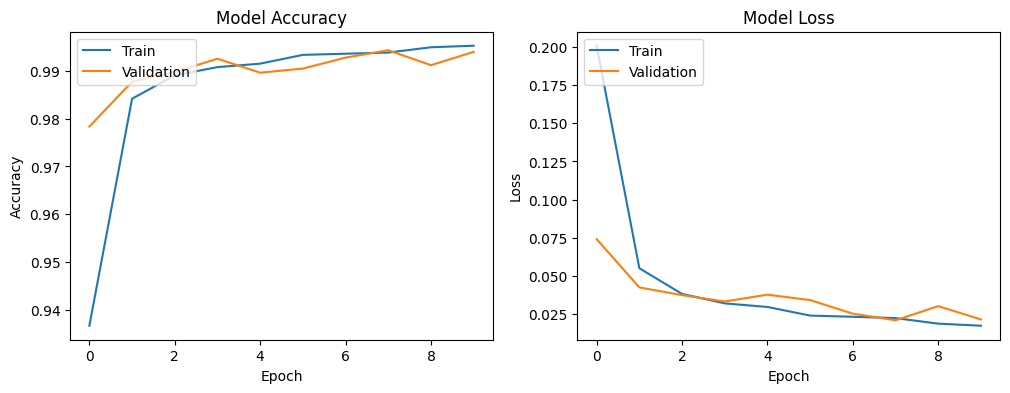

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Summarize history for accuracy
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

# Assuming 'history' is the returned object from model.fit()
plot_history(history)